# Set Season

In [1]:
season_string_notebook = 'SON'

### Download data

In [2]:
from download_files import download

download(period=season_string_notebook)

Downloaded ../data/CONUS.cpg
Downloaded ../data/CONUS.dbf
Downloaded ../data/CONUS.prj
Downloaded ../data/CONUS.sbn
Downloaded ../data/CONUS.sbx
Downloaded ../data/CONUS.shp
Downloaded ../data/CONUS.shp.xml
Downloaded ../data/CONUS.shx
Downloaded ../data/all_rain_future_4p5_SON_sums_75km.nc
Downloaded ../data/all_rain_future_8p5_SON_sums_75km.nc
Downloaded ../data/all_rain_historical_SON_sums_75km.nc
Downloaded ../data/mcs_rain_future_4p5_SON_sums_75km.nc
Downloaded ../data/mcs_rain_future_8p5_SON_sums_75km.nc
Downloaded ../data/mcs_rain_historical_SON_sums_75km.nc
Downloaded ../data/non_mcs_rain_future_4p5_SON_sums_75km.nc
Downloaded ../data/non_mcs_rain_future_8p5_SON_sums_75km.nc
Downloaded ../data/non_mcs_rain_historical_SON_sums_75km.nc


## Read in the data

In [3]:
import xarray as xr

data = {}

for event_type in ['all_rain', 'mcs_rain', 'non_mcs_rain']:
    
    data[event_type] = {}
    
    for simulation in ['historical', 'future_4p5', 'future_8p5']:
        
        data[event_type][simulation] = {}
        
        for season in [season_string_notebook]:
        
            data[event_type][simulation][season] = {}

            ds_event = xr.open_dataset(f"../data/{event_type}_{simulation}_{season}_sums_75km.nc")

            data[event_type][simulation][season]['seasons_sums'] = ds_event
            data[event_type][simulation][season]['seasons_mean'] = ds_event.mean('time')
            
data['all_rain']['historical'][season_string_notebook]['seasons_sums']

<xarray.Dataset>
Dimensions:   (time: 15, south_north: 44, west_east: 69)
Coordinates:
  * time      (time) datetime64[ns] 1990-10-01 1991-10-01 ... 2004-10-01
    lat       (south_north, west_east) float32 ...
    lon       (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Data variables:
    mcs_mask  (time, south_north, west_east) float32 6.508 8.079 ... 122.1 129.4
Attributes:
    info_read:      ds = xr.open_mfdataset(f'redacted/Analysis_Datasets/rain_...
    filtering:      ds = ds.where(ds.time.dt.month.isin(months)) #where month...
    info_resample:  ds.resample(time='AS-OCT').sum('time')
    english:        I am opening all of the all rain 1-hr rainfall totals tha...
    made_on:        Calculated by A. Haberlie on April 28th 2023
    date_range:     Start of 1990-10-01T00:00:00.000000000 to start of 2005-0...
    simulation:     historical
    units:          mm
    month_count:    45
    years_count:    15
    note:           the time dimension represents the water year of each seas...

### Create ratios of MCS to ALL Precipitation

In [4]:
data['mcs_ratio'] = {}

for simulation in ['historical', 'future_4p5', 'future_8p5']:
    
    data['mcs_ratio'][simulation] = {}
    
    for season in [season_string_notebook]:
        
        data['mcs_ratio'][simulation][season] = {}
        
        mcs_seasons = data['mcs_rain'][simulation][season]['seasons_sums']
        all_seasons = data['all_rain'][simulation][season]['seasons_sums']

        seasons_ratio =  mcs_seasons / all_seasons

        mcs_means = data['mcs_rain'][simulation][season]['seasons_mean']
        all_means = data['all_rain'][simulation][season]['seasons_mean']

        means_ratio =  mcs_means / all_means

        data['mcs_ratio'][simulation][season]['seasons_sums'] = seasons_ratio
        data['mcs_ratio'][simulation][season]['seasons_mean'] = means_ratio

### Set up mapping utilities and customization

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import copy
import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib.colors as colors

from ax import setup_map, draw_outlines, grid_significance
    
projection = cartopy.crs.LambertConformal(central_longitude=-96, central_latitude=37.5, standard_parallels=(29.5, 45.5))

#Blue Yellow for original accumulation in mm
mm_cmap = colors.ListedColormap(['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8'])
mm_cmap.set_under('grey')
mm_cmap.set_over('#0c2c84')

mm_values = [1, 50, 100, 150, 200, 250, 300]
mm_norm = colors.BoundaryNorm(mm_values, ncolors=mm_cmap.N)

#Blue Red for ratios
ratio_cmap = colors.ListedColormap(['#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3'][::-1])
ratio_cmap.set_under('grey')
ratio_cmap.set_over('#b2182b')

ratio_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
ratio_norm = colors.BoundaryNorm(ratio_values, ncolors=ratio_cmap.N)

#Blue Brown for differences in mm
diff_cmap = colors.ListedColormap(['#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f'])
diff_cmap.set_under('#8c510a')
diff_cmap.set_over('#01665e')

diff_values = [-150, -100, -50, 0, 50, 100, 150]
diff_norm = colors.BoundaryNorm(diff_values, ncolors=diff_cmap.N)

#Green Purple for ratio differences
ratio_diff_cmap = colors.ListedColormap(['#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41'])
ratio_diff_cmap.set_under('#c51b7d')
ratio_diff_cmap.set_over('#4d9221')

ratio_diff_values = [-0.5, -0.25, -0.1, 0, 0.1, 0.25, 0.5]
ratio_diff_norm = colors.BoundaryNorm(ratio_diff_values, ncolors=ratio_diff_cmap.N)

### Plot original values

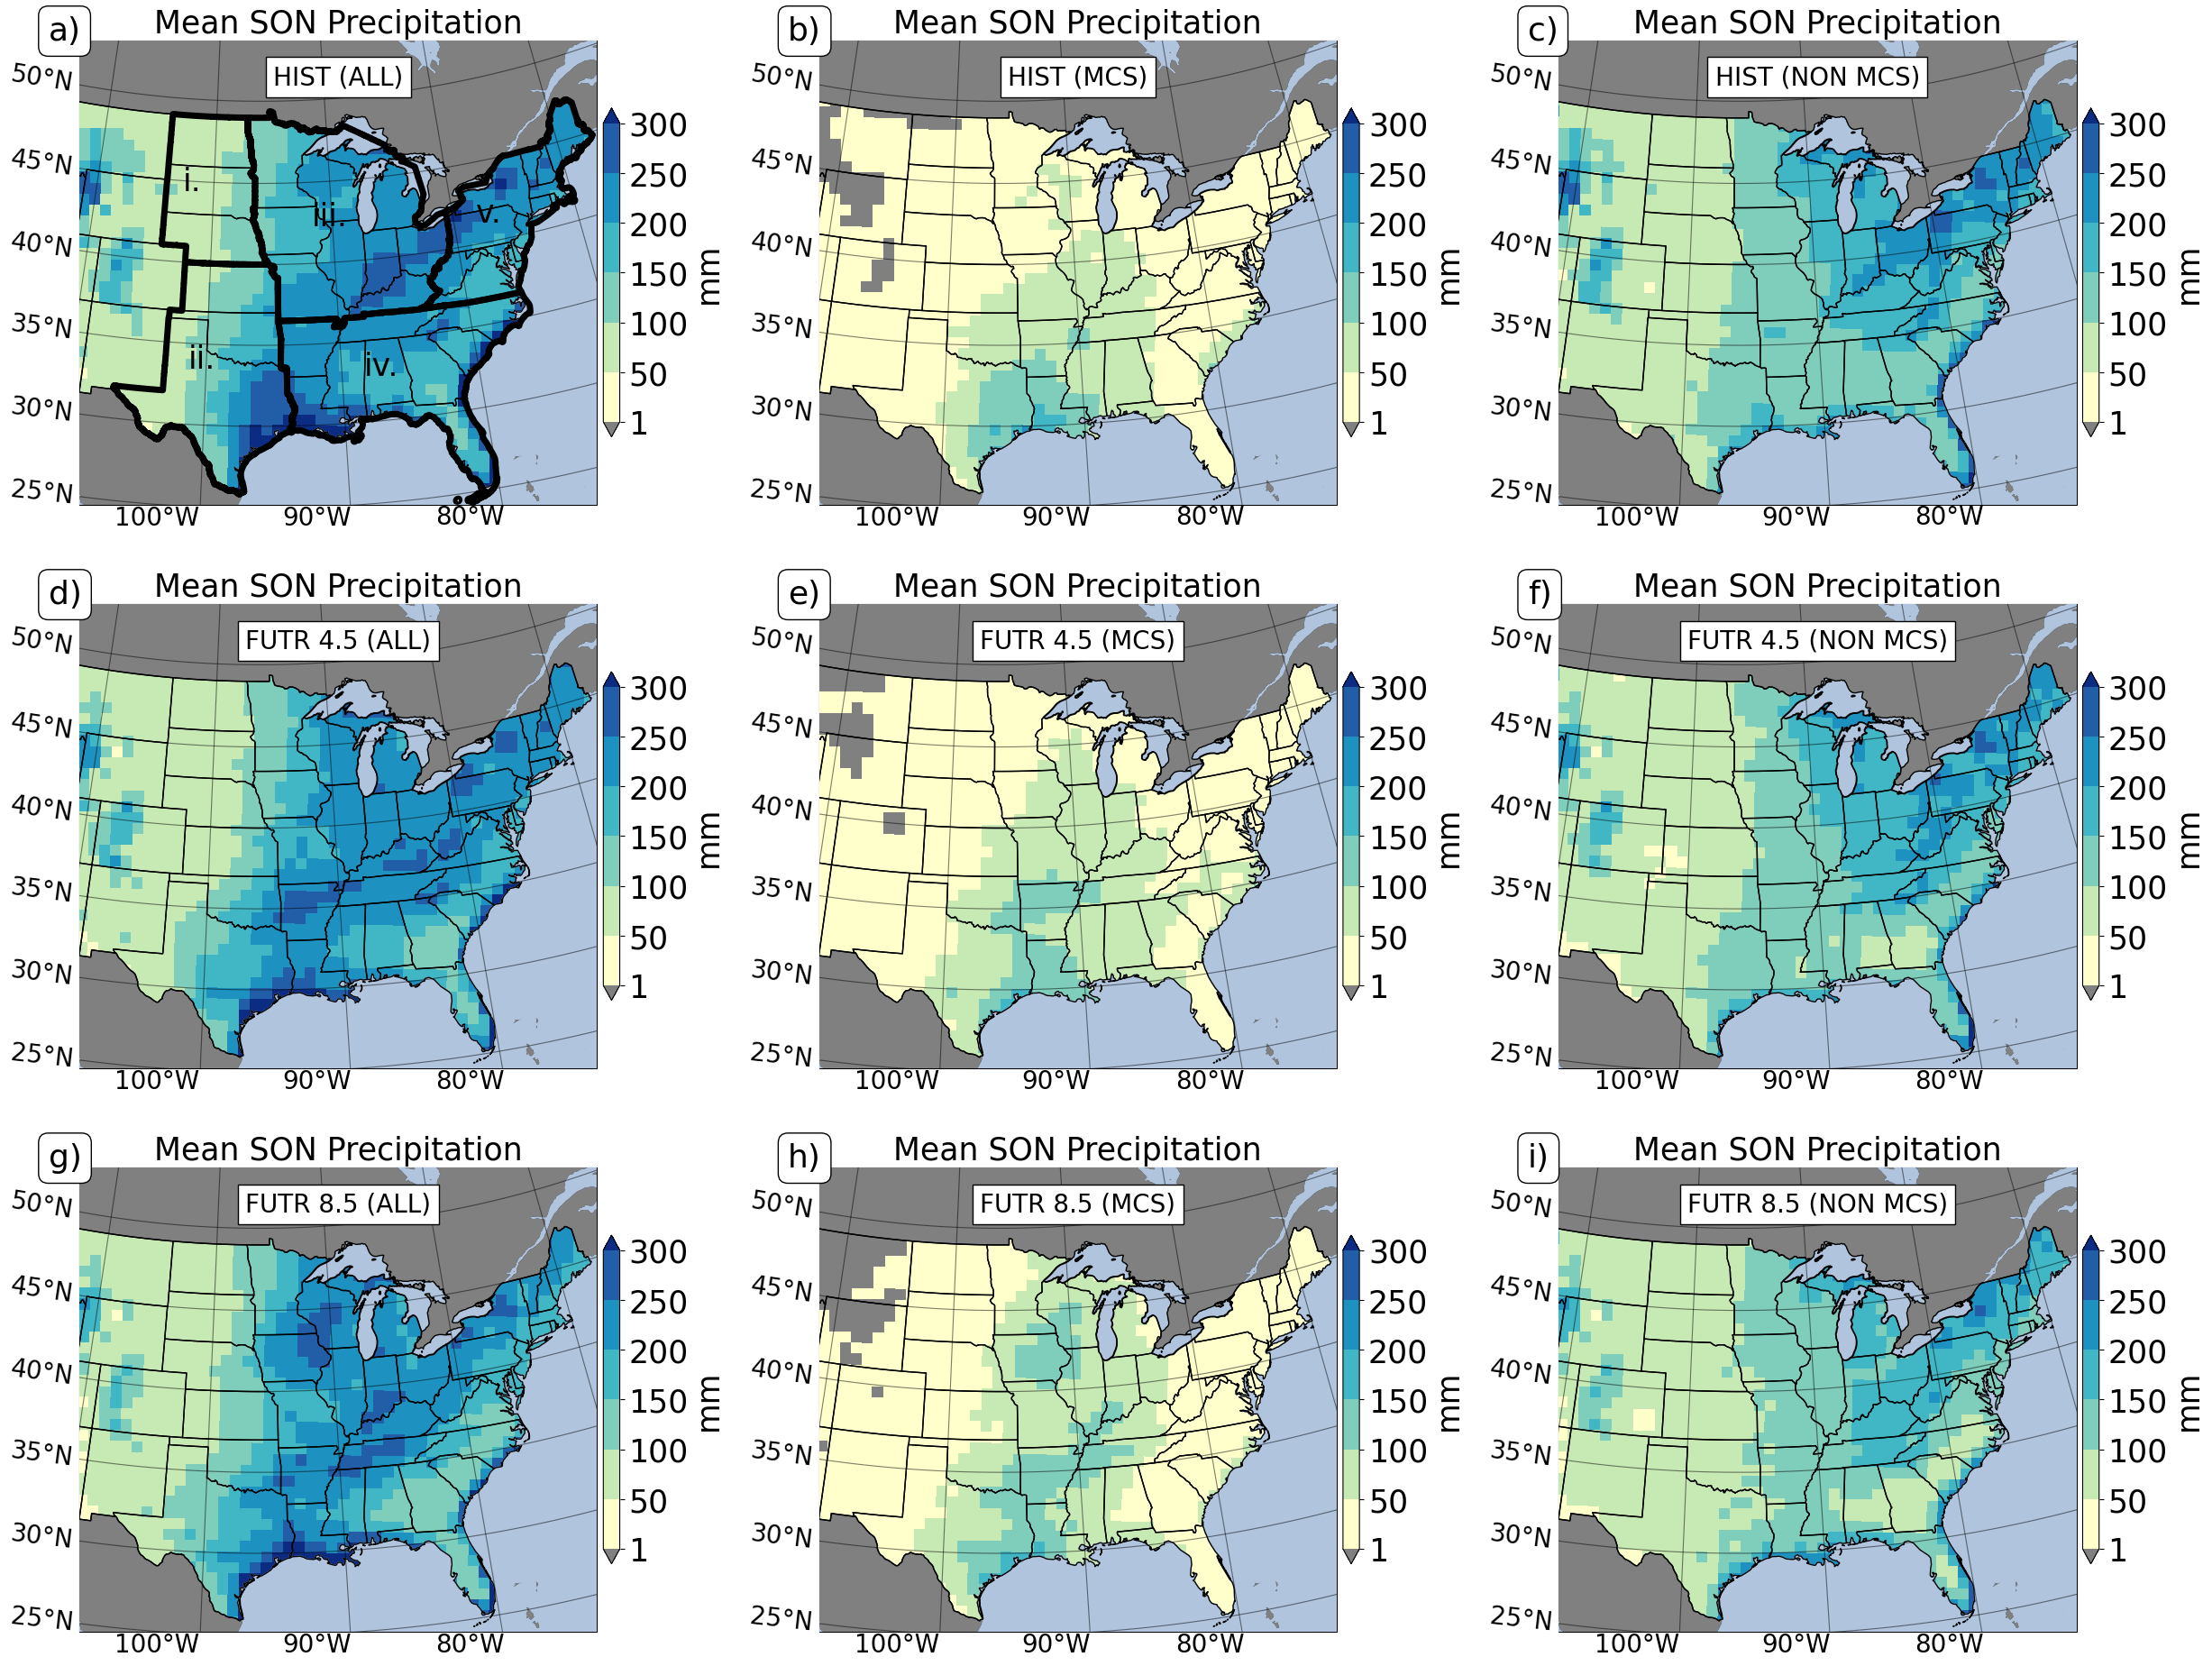

In [6]:
plt.rcParams['figure.figsize'] = 30, 23
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 25

simulation_names = {'historical': 'HIST', 'future_4p5': 'FUTR 4.5', 'future_8p5': 'FUTR 8.5'}
event_types = {'all_rain': 'ALL', 'mcs_rain': 'MCS', 'non_mcs_rain': 'NON MCS'}

for season in [season_string_notebook]:

    for row, (sim_name, sim_abbr) in enumerate(simulation_names.items()):

        for col, (event_name, event_abbr) in enumerate(event_types.items()):

            ax_pos = 1 + ((row * 3) + col)

            simulation_means = data[event_name][sim_name][season]['seasons_mean']

            ax = setup_map(ax_pos, 3, 3, ax_pos)

            ax.set_title(f"Mean {season} Precipitation")

            ax.annotate(f"{sim_abbr} ({event_abbr})", (0.5,0.92), 
                        xycoords='axes fraction', ha='center', va='center',
                        fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                        color='k', zorder=15)

            if ax_pos == 1:

                draw_outlines(ax)

            mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                                simulation_means['mcs_mask'], 
                                norm=mm_norm, transform=cartopy.crs.PlateCarree(), 
                                cmap=mm_cmap, zorder=5)

            cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', pad=0.01)

            cbar.set_label(label="mm")
        
plt.savefig(f"original_season_{season}_080223.png", dpi=200, bbox_inches='tight')

### Plot MCS ratios

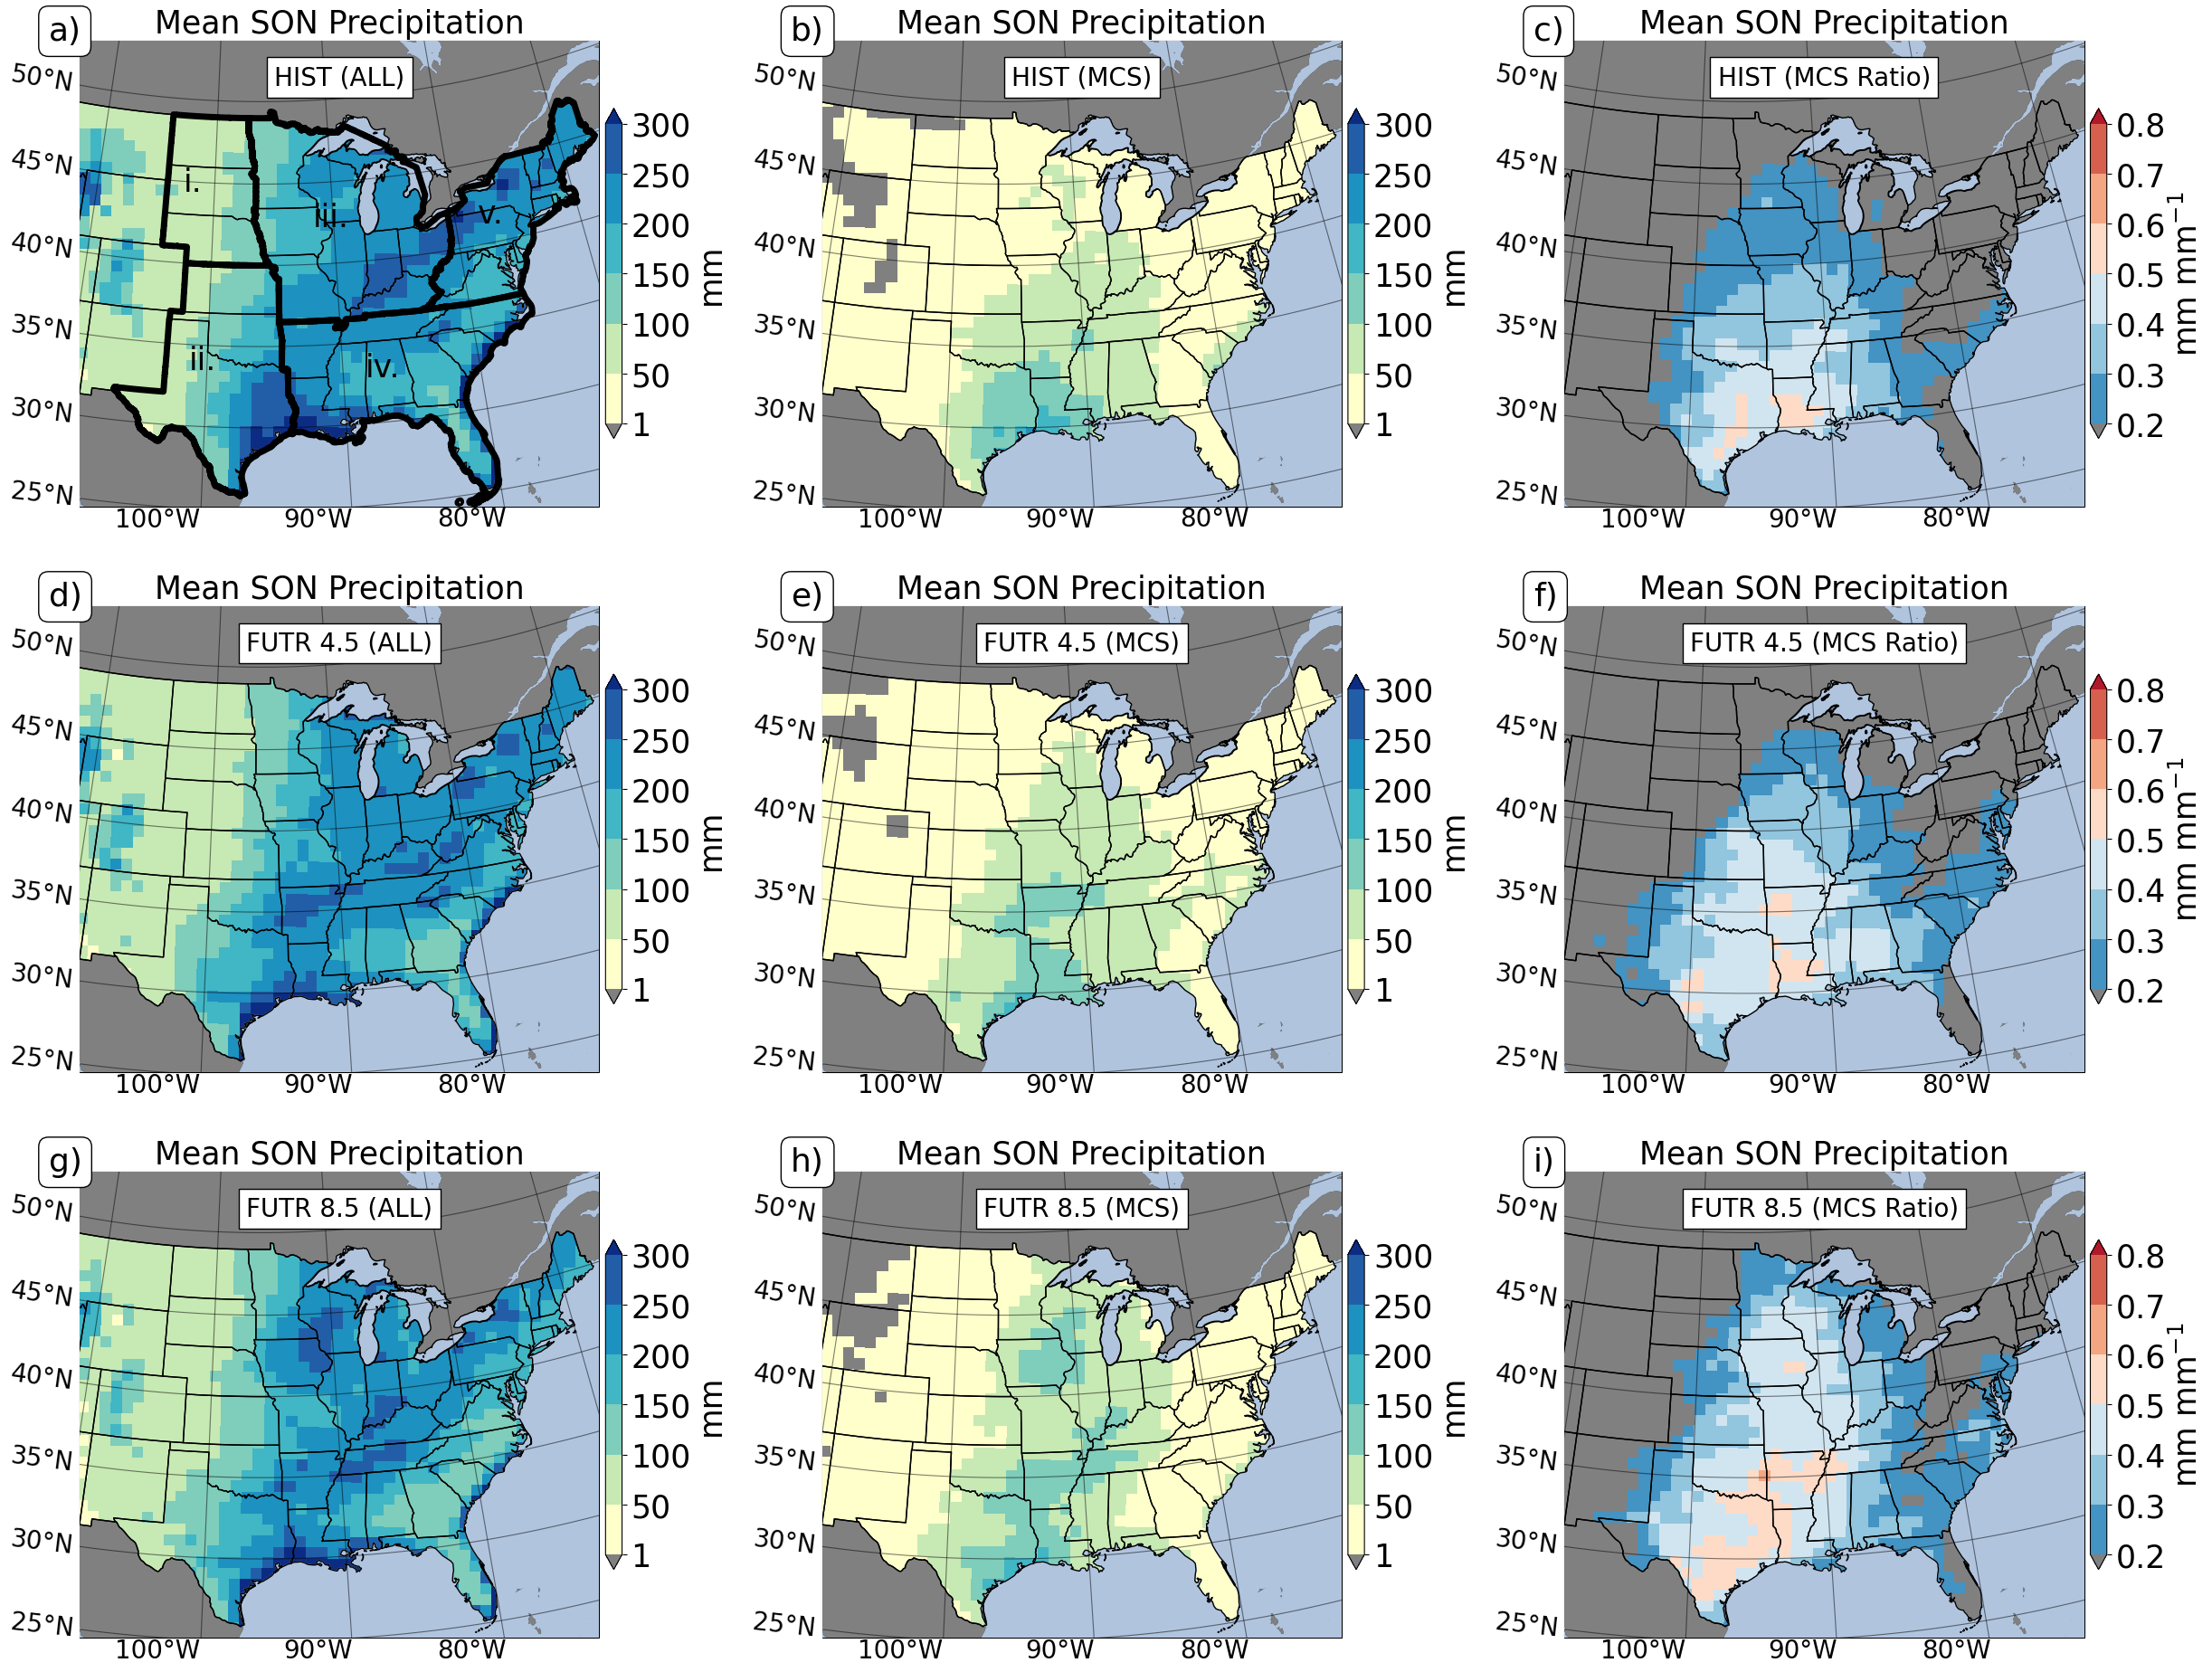

In [7]:
simulation_names = {'historical': 'HIST', 'future_4p5': 'FUTR 4.5', 'future_8p5': 'FUTR 8.5'}

event_types = {'all_rain': {'abbr': 'ALL', 'cmap': mm_cmap, 'norm': mm_norm, 'units': 'mm'},
               'mcs_rain': {'abbr': 'MCS', 'cmap': mm_cmap, 'norm': mm_norm, 'units': 'mm'}, 
               'mcs_ratio': {'abbr': 'MCS Ratio', 'cmap': ratio_cmap, 'norm': ratio_norm, 'units': 'mm mm$^{-1}$'}}

for season in [season_string_notebook]:

    for row, (sim_name, sim_abbr) in enumerate(simulation_names.items()):

        for col, (event_name, event_info) in enumerate(event_types.items()):

            ax_pos = 1 + ((row * 3) + col)

            simulation_means = data[event_name][sim_name][season]['seasons_mean']

            ax = setup_map(ax_pos, 3, 3, ax_pos)

            ax.set_title(f"Mean {season} Precipitation")

            ax.annotate(f"{sim_abbr} ({event_info['abbr']})", (0.5,0.92), 
                        xycoords='axes fraction', ha='center', va='center',
                        fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                        color='k', zorder=15)

            if ax_pos == 1:

                draw_outlines(ax)

            mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                                simulation_means['mcs_mask'], cmap=event_info['cmap'],
                                norm=event_info['norm'], transform=cartopy.crs.PlateCarree(), 
                                zorder=5)

            cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', pad=0.01)

            cbar.set_label(label=event_info['units'])

plt.savefig(f"ratio_season_{season}_080223.png", dpi=200, bbox_inches='tight')

### Plot precipitation differences

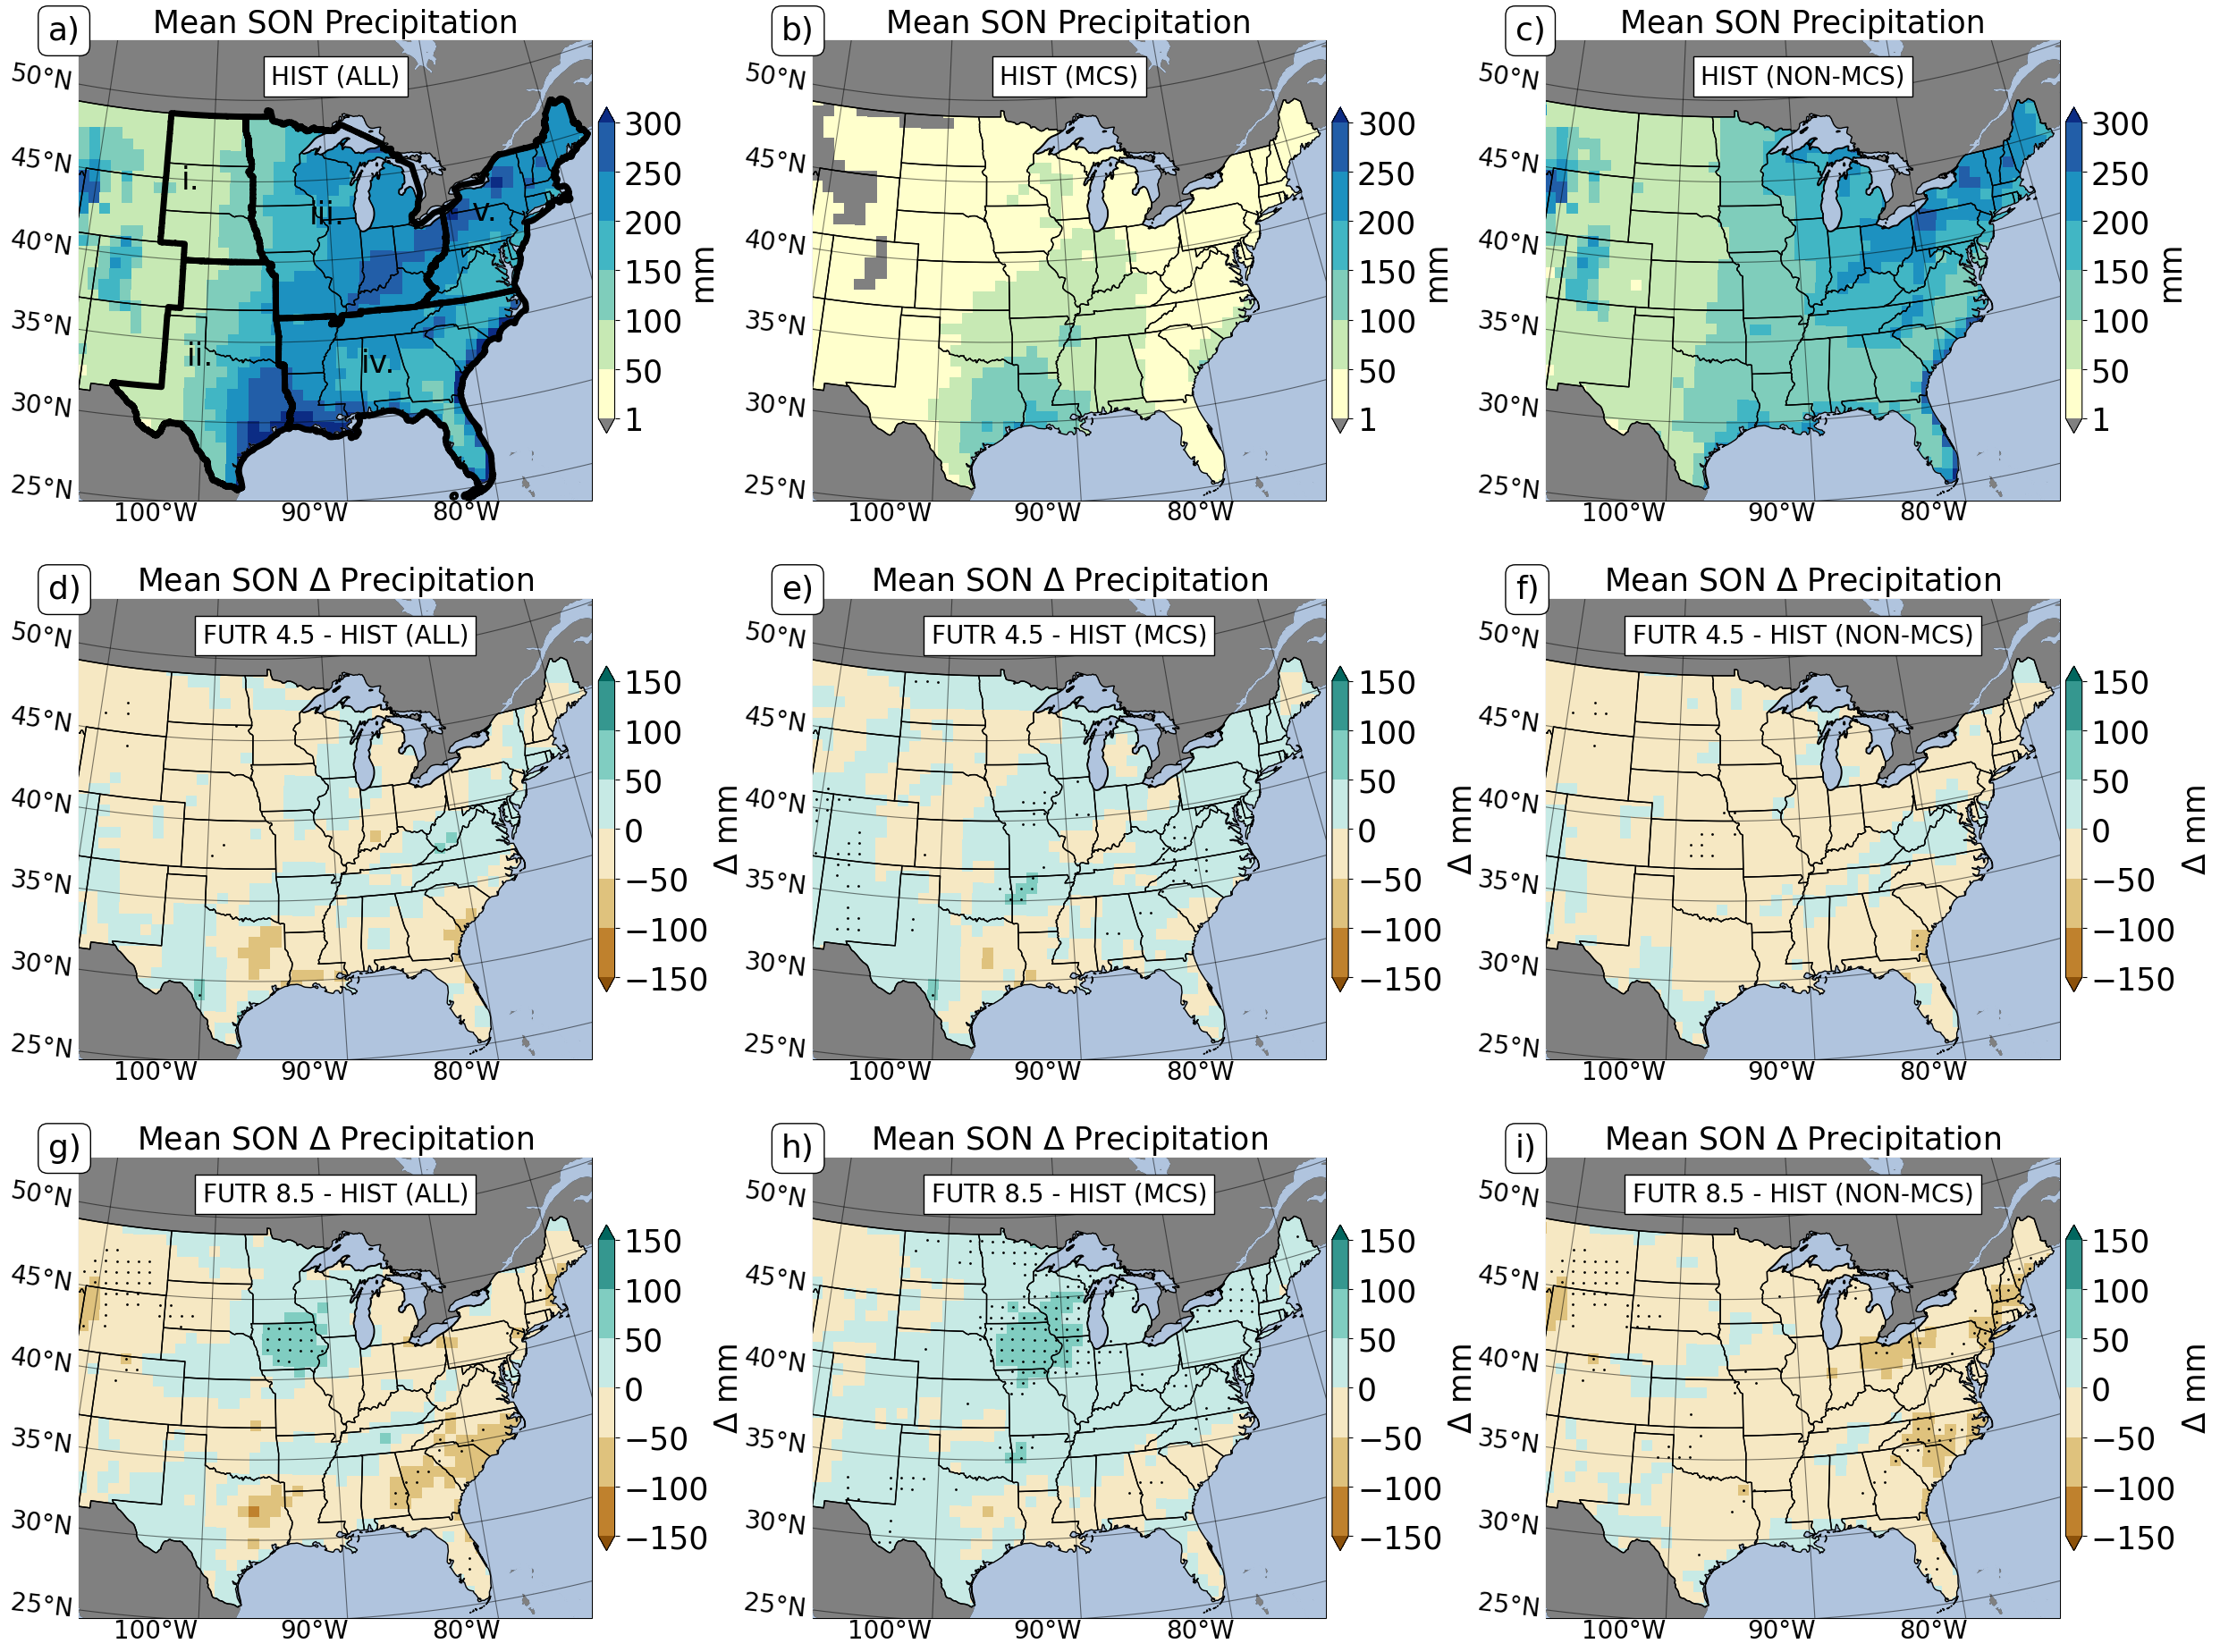

In [8]:
simulation_names = {'historical': {'abbr': 'HIST', 'cmap': mm_cmap, 'norm': mm_norm, 'units': 'mm'},
                    'future_4p5': {'abbr': 'FUTR 4.5 - HIST', 'cmap': diff_cmap, 
                                   'norm': diff_norm, 'units': '$\Delta$ mm'},
                    'future_8p5': {'abbr': 'FUTR 8.5 - HIST', 'cmap': diff_cmap, 
                                   'norm': diff_norm, 'units': '$\Delta$ mm'}}

event_types = {'all_rain': 'ALL', 'mcs_rain': 'MCS', 'non_mcs_rain': 'NON-MCS'}


for season in [season_string_notebook]:
    for row, (sim_name, sim_info) in enumerate(simulation_names.items()):
        for col, (event_name, event_info) in enumerate(event_types.items()):

            ax_pos = 1 + ((row * 3) + col)

            ax = setup_map(ax_pos, 3, 3, ax_pos)

            ax.annotate(f"{sim_info['abbr']} ({event_info})", (0.5,0.92), 
                        xycoords='axes fraction', ha='center', va='center',
                        fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                        color='k', zorder=15)

            cmap = plt.cm.get_cmap(sim_info['cmap']).copy()

            simulation_means = data[event_name][sim_name][season]['seasons_mean'] 

            ax.set_title(f"Mean {season} Precipitation")

            if sim_name != 'historical':

                ax.set_title(f"Mean {season} $\Delta$ Precipitation")

                sim_means = data[event_name][sim_name][season]['seasons_mean'] 
                hist_means = data[event_name]['historical'][season]['seasons_mean']

                simulation_means = sim_means - hist_means

            else:

                cmap.set_under('grey')

            if ax_pos == 1:

                draw_outlines(ax)

            mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                                simulation_means['mcs_mask'], cmap=sim_info['cmap'],
                                transform=cartopy.crs.PlateCarree(), 
                                norm=sim_info['norm'], zorder=5)

            cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', pad=0.01)

            cbar.set_label(label=sim_info['units'])

            sim_years = data[event_name][sim_name][season]['seasons_sums']
            hist_years = data[event_name]['historical'][season]['seasons_sums']

            sig = grid_significance(hist_years['mcs_mask'].values, sim_years['mcs_mask'].values)

            pts_sig = np.where(sig < 0.05)

            ax.plot(simulation_means.lon.values[pts_sig],
                    simulation_means.lat.values[pts_sig],
                    'k.', ms=2, transform=cartopy.crs.PlateCarree(), zorder=5)


plt.savefig(f"Figure1_{season}_080223.png", dpi=200, bbox_inches='tight')

### Plot ratio changes

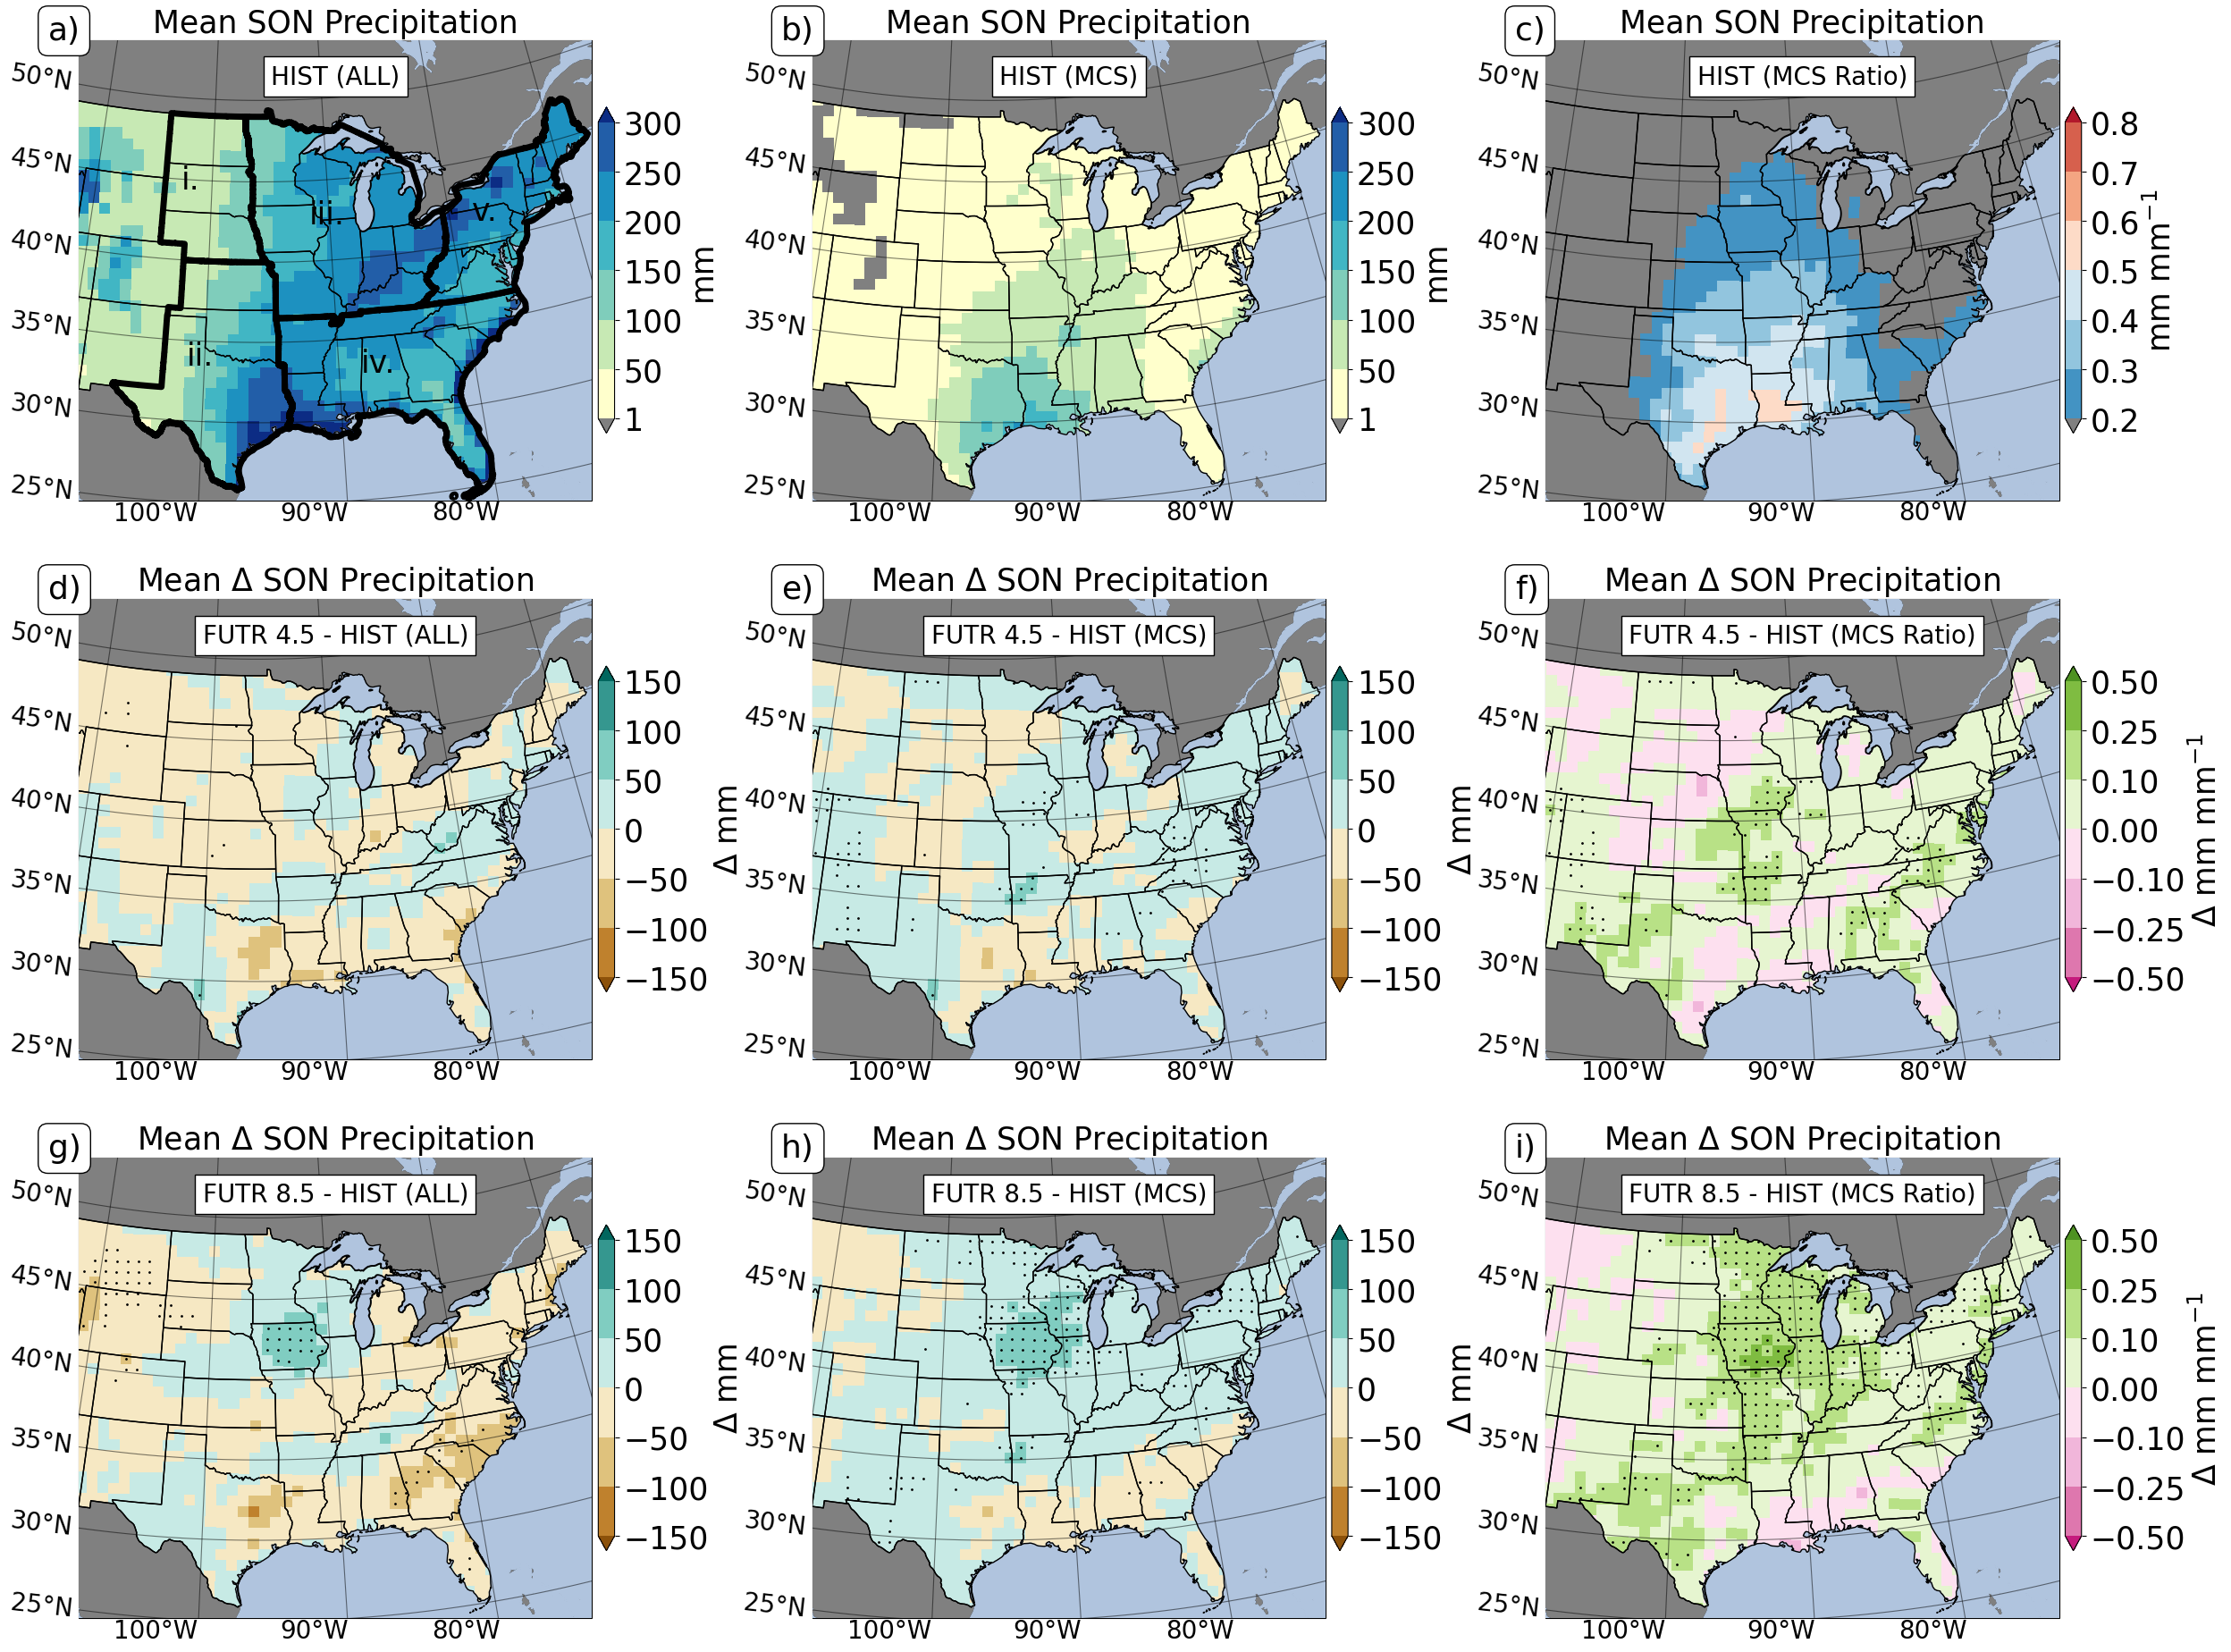

In [9]:
plt.rcParams['figure.figsize'] = 30, 23
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 25

simulation_names = {'historical': 'HIST'}

event_types = {'all_rain': {'abbr': 'ALL', 'cmap': mm_cmap, 'norm': mm_norm, 'units': 'mm'},
               'mcs_rain': {'abbr': 'MCS', 'cmap': mm_cmap, 'norm': mm_norm, 'units': 'mm'}, 
               'mcs_ratio': {'abbr': 'MCS Ratio', 'cmap': ratio_cmap, 
                             'norm': ratio_norm, 'units': 'mm mm$^{-1}$'}}


for season in [season_string_notebook]:

    for row, (sim_name, sim_info) in enumerate(simulation_names.items()):
        for col, (event_name, event_info) in enumerate(event_types.items()):

            ax_pos = 1 + ((row * 3) + col)

            ax = setup_map(ax_pos, 3, 3, ax_pos)

            ax.annotate(f"{sim_info} ({event_info['abbr']})", (0.5,0.92), 
                        xycoords='axes fraction', ha='center', va='center',
                        fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                        color='k', zorder=15)


            simulation_means = data[event_name][sim_name][season]['seasons_mean'] 

            ax.set_title(f"Mean {season} Precipitation")

            if ax_pos == 1:

                draw_outlines(ax)

            mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                            simulation_means['mcs_mask'].values, 
                            norm=event_info['norm'], cmap=event_info['cmap'], transform=cartopy.crs.PlateCarree(), 
                            zorder=5)

            cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', pad=0.01)

            cbar.set_label(label=event_info['units'])

    simulation_names = {'future_4p5': 'FUTR 4.5 - HIST', 'future_8p5': 'FUTR 8.5 - HIST'}

    event_types = {'all_rain': {'abbr': 'ALL', 'cmap': diff_cmap, 
                                'norm': diff_norm, 'units': '$\Delta$ mm'},
                   'mcs_rain': {'abbr': 'MCS', 'cmap': diff_cmap, 
                                'norm': diff_norm, 'units': '$\Delta$ mm'}, 
                   'mcs_ratio': {'abbr': 'MCS Ratio', 'cmap': ratio_diff_cmap, 
                                 'norm': ratio_diff_norm, 'units': '$\Delta$ mm mm$^{-1}$'}}
    
    for row, (sim_name, sim_info) in enumerate(simulation_names.items()):
        for col, (event_name, event_info) in enumerate(event_types.items()):

            ax_pos = 1 + (((row+1) * 3) + col)

            ax = setup_map(ax_pos, 3, 3, ax_pos)

            ax.set_title(f"Mean $\Delta$ {season} Precipitation")
            
            ax.annotate(f"{sim_info} ({event_info['abbr']})", (0.5,0.92), 
                        xycoords='axes fraction', ha='center', va='center',
                        fontsize=20, bbox=dict(boxstyle='square', facecolor='w', alpha=1), 
                        color='k', zorder=15)

            simulation_means = data[event_name][sim_name][season]['seasons_mean']
            historical_means = data[event_name]['historical'][season]['seasons_mean']

            mmp = ax.pcolormesh(simulation_means.lon, simulation_means.lat, 
                            simulation_means['mcs_mask'].values - historical_means['mcs_mask'].values, 
                            norm=event_info['norm'], cmap=event_info['cmap'], transform=cartopy.crs.PlateCarree(), 
                            zorder=5)

            cbar = plt.colorbar(mmp, ax=ax, shrink=0.7, extend='both', pad=0.01)

            cbar.set_label(label=event_info['units'])

            sim_years = data[event_name][sim_name][season]['seasons_sums']
            hist_years = data[event_name]['historical'][season]['seasons_sums']

            sig = grid_significance(hist_years['mcs_mask'].values, sim_years['mcs_mask'].values)

            pts_sig = np.where(sig < 0.05)

            ax.plot(simulation_means.lon.values[pts_sig],
                    simulation_means.lat.values[pts_sig],
                    'k.', ms=2, transform=cartopy.crs.PlateCarree(), zorder=5)
            
plt.savefig(f"Figure_ratio_{season}_080223.png", dpi=200, bbox_inches='tight')